In [1]:
# 딥드림 : 인셉션3
# V3<- 이미지입력, 특정층에서 경사를 계산해서 해당층의 활성화를 최대화하도록 이미지를 수정 10,20 40

In [2]:
# 옥타브: 간격, 일정한 간격을 두고 딥드림 알고리즘을 적용
# 1. 이미지를 몇 차례 축소해서 다양한 배율의 이미지를 만들고  각 배율마다
# 2. 세부묘사 주입 : 합성된 이미지를 만드는 과정에서 이미지를 확대하여 잃어버린 세부 묘사를 재 주입
# 3. 딥드림 알고리즘 수행 : 합성된 이미지를 딥 드립 알고리즘으로 입력
# 4 다음간격까지 이미지를 확대

In [3]:
from tensorflow import keras
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

In [4]:
# for layer in model.layers:
#   if 'mixed' in layer.name:
#     print(layer.name)

layer_contributions = {
  'mixed2':0.4,
  'mixed3':2.0,
  'mixed4':1.5,
  'mixed5':2.3
}
outputs_dict = dict([(layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_contributions.keys()]])
feature_extractor = keras.Model(inputs = model.input, outputs = outputs_dict)

In [5]:
# 손실값을 함수형태로 재 구성
import tensorflow as tf
def fn_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_contributions[name]
    activation = features[name]
    loss += coeff + tf.reduce_mean(tf.square(activation[:,2:-2,2:-2,:]))
  return loss

In [6]:
# 딥드림의 경사 상승법
@tf.function
def gradient_ascent_step(image,learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = fn_loss(image)
  grads = tape.gradient(loss,image)
  # 규제 L2 norm
  grads = tf.math.l2_normalize(grads)
  image += learning_rate * grads
  return loss,image

In [7]:
def gradient_ascent_loop(image, iterations, learning_rate, max_loss = None):
  for i in range(iterations):
    loss,image = gradient_ascent_step(image,learning_rate)
    if max_loss is not None and loss > max_loss:
      break
    print(f"step {i} : loss {loss:.4f}")
  return image

In [8]:
# 하이퍼 파라메터
step = 20
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [9]:
import numpy as np
def preprocess_image(image_path):
  img = keras.utils.load_img(image_path)
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img,axis=0)  
  img = keras.applications.inception_v3.preprocess_input(img)
  return img
def deprocess_image(img):
  img = img.reshape((img.shape[1],img.shape[2],3  ))
  img += 1.0
  img *= 100
  img = np.clip(img,0,255).astype('uint8')
  return img

In [27]:
# 여러개의 옥타브를 거쳐서 경사 상승법을 실행
base_image_path = keras.utils.get_file('base.jpg', origin='https://www.google.com/imgres?imgurl=https%3A%2F%2Fimages.pexels.com%2Fphotos%2F3081487%2Fpexels-photo-3081487.jpeg%3Fcs%3Dsrgb%26dl%3Dpexels-stein-egil-liland-3081487.jpg%26fm%3Djpg&imgrefurl=https%3A%2F%2Fwww.pexels.com%2Fko-kr%2Fsearch%2F%25ED%2592%258D%25EA%25B2%25BD%2520%25EC%2582%25AC%25EC%25A7%2584%2F&tbnid=QUyBpJr4h7HcoM&vet=12ahUKEwjqu7_6mpn8AhULRvUHHY_jBg0QMygwegUIARDMAg..i&docid=kUYm5VMHEZ70OM&w=4928&h=3280&q=%ED%92%8D%EA%B2%BD&ved=2ahUKEwjqu7_6mpn8AhULRvUHHY_jBg0QMygwegUIARDMAg')
base_image = keras.utils.load_img(base_image_path)

/root/.keras/datasets/base.jpg


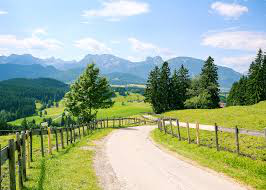

In [28]:
print(base_image_path)
base_image

In [21]:
original_img = preprocess_image(base_image_path)

In [22]:
original_shape =  original_img.shape[1:3]
successive_shape = [original_shape]
for i in range(1, num_octave):
  shape =  tuple([ int( dim / (octave_scale**i)  ) for dim in original_shape])
  successive_shape.append(shape)
successive_shape = successive_shape[::-1]

In [23]:
shrunk_original_img =  tf.image.resize(original_img, successive_shape[0])

In [24]:
img = tf.identity(original_img)  # 입력과 모양이 같은 tensor를 반환  deep copy

In [25]:
from codecs import iterencode
for i, shape in enumerate(successive_shape):
  print(f"{shape} {i}번째 옥타브 처리.................................")
  img = tf.image.resize(img,shape)
  img = gradient_ascent_loop(img, iterations = iterations, learning_rate=step, max_loss = max_loss)
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original =  tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img,shape)

(96, 135) 0번째 옥타브 처리.................................
step 0 : loss nan
step 1 : loss nan
step 2 : loss nan
step 3 : loss nan
step 4 : loss nan
step 5 : loss nan
step 6 : loss nan
step 7 : loss nan
step 8 : loss nan
step 9 : loss nan
step 10 : loss nan
step 11 : loss nan
step 12 : loss nan
step 13 : loss nan
step 14 : loss nan
step 15 : loss nan
step 16 : loss nan
step 17 : loss nan
step 18 : loss nan
step 19 : loss nan
step 20 : loss nan
step 21 : loss nan
step 22 : loss nan
step 23 : loss nan
step 24 : loss nan
step 25 : loss nan
step 26 : loss nan
step 27 : loss nan
step 28 : loss nan
step 29 : loss nan
(135, 190) 1번째 옥타브 처리.................................
(190, 266) 2번째 옥타브 처리.................................


In [26]:
keras.utils.save_img('createdImg.png', deprocess_image(img.numpy()) )